# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Чтобы усилить исследование, не будем ограничиваться градиентным бустингом. Попробуем более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируем и сравним характеристики моделей: скорость работы, точность результата.

**План исследования:**
* Загрузим и подготовим данные.
* Обучим разные модели. Для каждой попробуем различные гиперпараметры.
* Проанализируем скорость работы и качество моделей.

<i>Примечания:</i>
* Для оценки качества моделей применим метрику RMSE.
  Значение метрики RMSE должно быть меньше 2500.


## Подготовка данных

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузка данных
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('https:://code.s3.yandex.net/datasets/autos.csv')

In [ ]:
# Изучим данные
data.info()
print()
data.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,0,1,2,3,4
DateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04,2016-03-31 17:25:20
Price,480,18300,9800,1500,3600
VehicleType,NaN,coupe,suv,small,small
RegistrationYear,1993,2011,2004,2001,2008
Gearbox,manual,manual,auto,manual,manual
Power,0,190,163,75,69
Model,golf,NaN,grand,golf,fabia
Kilometer,150000,125000,125000,150000,90000
RegistrationMonth,0,5,8,6,7
FuelType,petrol,gasoline,gasoline,petrol,gasoline


Знакомимся с признаками

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

In [ ]:
# Для начала приведем названия столбцов к нижнему регистру
data.columns = map(str.lower, data.columns)

In [ ]:
# Изучим наличие дубликатов
data.duplicated().sum()

4

In [ ]:
# Удалим дубликаты
data = data.drop_duplicates()

In [ ]:
# Оценим количество пропусков
data.isna().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

Довольно большая доля пропусков в признаках: *VehicleType*, *Gearbox*, *Model*, *FuelType*, *NotRepaired*. 
Попробуем заменить пропуски самыми частотными значениями по признаку, тем более это категориальные значения.

In [ ]:
# Заполнение пропусков самым частотным значением для признака
data['vehicletype'] = data['vehicletype'].fillna(data['vehicletype'].mode().values[0])
data['gearbox'] = data['gearbox'].fillna(data['gearbox'].mode().values[0])
data['model'] = data['model'].fillna(data['model'].mode().values[0])
data['fueltype'] = data['fueltype'].fillna(data['fueltype'].mode().values[0])
data['notrepaired'] = data['notrepaired'].fillna("no")

In [ ]:
# Приведение признаков даты к типу datetime
date_columns = ['datecrawled' , 'datecreated', 'lastseen']
for time in date_columns:
    data[time] = pd.to_datetime(data[time], format = '%Y.%m.%d %H:%M:%S')

In [ ]:
# Рассмотрим численные признаки на явные выбросы
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Есть выбросы в столбце RegistrationYear с минимумом в 1000 и максимальным значением 9999. Отсечем заведомо аномальные значения с регистрацией ранее 1900 года и позднее 2016 года.

count    330170.000000
mean       2002.089236
std           6.802969
min        1910.000000
25%        1999.000000
50%        2002.000000
75%        2007.000000
max        2015.000000
Name: registrationyear, dtype: float64

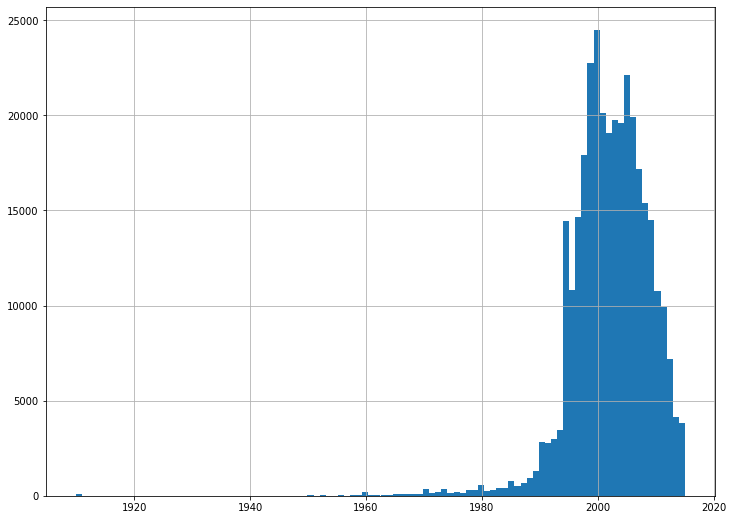

In [ ]:
data = data.query('1900 < registrationyear < 2016')
data['registrationyear'].hist(bins=100, figsize=(12,9))
data['registrationyear'].describe()

В столбце Power также заметны аномалии с нулевыми значениями и данными мощности, превышающими лошадиные силы самого быстрого болида. Проведем замену аномальных значений медианными по каждой модели.

In [ ]:
data.loc[(data['power'] > 1000) | (data['power'] <= 0), 'power'] = None
data['power'] = data['power'].fillna(data.groupby('model')['power'].transform('median'))
data = data.loc[~data['power'].isna()]
data['power'] = data['power'].astype('int64')

count    330168.000000
mean        119.701937
std          53.658730
min           1.000000
25%          77.000000
50%         110.000000
75%         146.000000
max        1000.000000
Name: power, dtype: float64

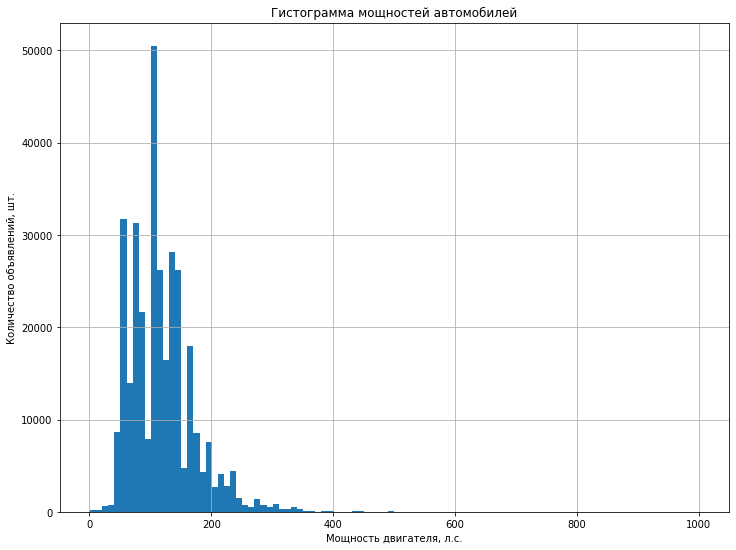

In [ ]:
data['power'].hist(bins=100, figsize=(12,9))
plt.title('Гистограмма мощностей автомобилей')
plt.xlabel('Мощность двигателя, л.с.')
plt.ylabel('Количество объявлений, шт.')
data['power'].describe()

Заменим отсутствующие данные месяца на самый частотный (после 0) месяц (по моде).

In [ ]:
data.loc[data['registrationmonth'] == 0, 'registrationmonth'] = data['registrationmonth'].value_counts().index[1]

In [ ]:
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,330168.000000,330168.000000,330168.000000,330168.000000,330168.000000,330168.0,330168.000000
mean,4540.158786,2002.089406,119.701937,127921.164377,5.789707,0.0,50692.404494
std,4564.412996,6.802631,53.658730,37913.067990,3.694135,0.0,25813.708279
min,0.000000,1910.000000,1.000000,5000.000000,0.000000,0.0,1067.000000
25%,1149.000000,1999.000000,77.000000,125000.000000,3.000000,0.0,30179.000000
50%,2850.000000,2002.000000,110.000000,150000.000000,6.000000,0.0,49565.000000
75%,6500.000000,2007.000000,146.000000,150000.000000,9.000000,0.0,71287.000000
max,20000.000000,2015.000000,1000.000000,150000.000000,12.000000,0.0,99998.000000


Для корректной работы моделей сбросим колонки с временными признаками - date_columns

In [ ]:
data = data.drop(date_columns, axis=1)

А еще имеет смысл удалить малозначимую колонку NumberOfPictures, в которой везде нули. Об этой ошибке стоит сообщить техническим специалистам.

In [ ]:
data = data.drop('numberofpictures', axis=1)

Изучим категорийные признаки

In [ ]:
cat_columns = list(data.select_dtypes(include='object').columns)

Закодируем категорийные признаки через Label Encoder

In [ ]:
le = LabelEncoder()
for column in cat_columns:
    le.fit(data[column].astype('str'))
    data[column] = le.transform(data[column].astype('str'))

<AxesSubplot:xlabel='price', ylabel='Density'>

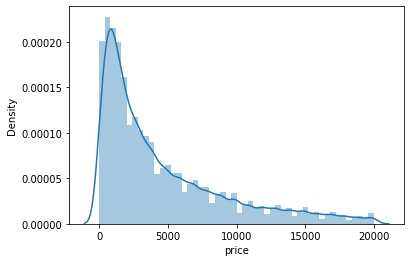

In [ ]:
# Посмотрим графическое представление целевого признака по плотности распределения цен
sns.distplot(data['price'])

count    319588.000000
mean       4690.454394
std        4562.745913
min          11.000000
25%        1250.000000
50%        2999.000000
75%        6800.000000
max       20000.000000
Name: price, dtype: float64

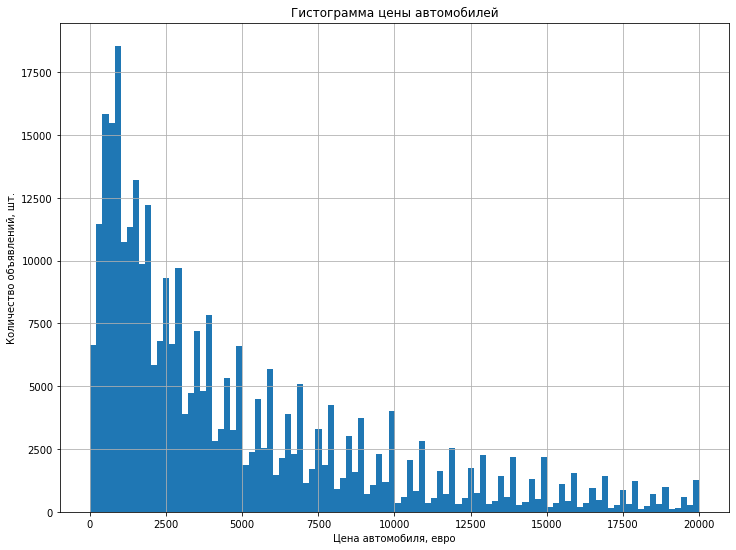

In [ ]:
data = data.query('price > 10')
data['price'].hist(bins=100, figsize=(12,9))
plt.title('Гистограмма цены автомобилей')
plt.xlabel('Цена автомобиля, евро')
plt.ylabel('Количество объявлений, шт.')
data['price'].describe()

**Выводы**

Проведено изучение и предобработка данных:
- удалены дубликаты
- данные в столбцах временных данных приведены к типу datetime
- пропуски заполнены самым частотным значением признаков
- удалены аномалии для данных с годом регистрации до 1900 и позднее 2016 года
- нулевые показатели мощности заменены медианными значениями признака по каждой модели
- для целей нашего исследования оставлены цены автомобилей больше 10 евро
- нулевые значения месяца регистрации заменены самым частотным месяцем - 01

## Обучение моделей

Создадим переменные для признаков и целевого признака.

In [ ]:
X = data.drop('price', axis=1)
y = data['price']

Разобьем данные на две части: обучающую и тестовую выборки в соотношении 70:30 соответственно

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [ ]:
# Размер обучающей выборки
X_train.shape

(223711, 11)

In [ ]:
# Размер тестовой выборки
X_test.shape

(95877, 11)

In [ ]:
# Введем функцию для подсчета метрики RMSE
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

### Линейная регрессия

In [ ]:
lr = LinearRegression()

In [ ]:
%%time
lr.fit(X_train, y_train)

CPU times: user 77.6 ms, sys: 26.9 ms, total: 104 ms
Wall time: 77.1 ms


LinearRegression()

In [ ]:
%%time
test_prediction_lr = lr.predict(X_test)

CPU times: user 16.5 ms, sys: 26 ms, total: 42.5 ms
Wall time: 78.6 ms


In [ ]:
print('RMSE:', rmse(y_test, test_prediction_lr))

RMSE: 2989.2481715463878


Задействуем технику прямого кодирования, чтобы преобразовать категориальные признаки в численные.

In [ ]:
# One-hot-encoding: получение дамми-признаков
data_X = pd.get_dummies(data, drop_first=True)
ohe_X = pd.get_dummies(X, drop_first=True)

In [ ]:
ohe_X_train = ohe_X.loc[X_train.index, :]
ohe_X_test = ohe_X.loc[X_test.index, :]

In [ ]:
%%time

regressor = LinearRegression()
cv_RMSE_lr = (cross_val_score(regressor, 
                             ohe_X_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE для линейной регрессии =', cv_RMSE_lr)

RMSE для линейной регрессии = 2994.679323815554
CPU times: user 586 ms, sys: 482 ms, total: 1.07 s
Wall time: 1.01 s


In [ ]:
# Линейная регрессия с масштабированием признаков
regressor = LinearRegression()
scaler = StandardScaler()
pipeline = Pipeline([("standard_scaler", scaler),("linear_regression", regressor)])
cv_RMSE_lr_scaled = (cross_val_score(pipeline,
                                ohe_X_train, 
                                y_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE для линейной регрессии с масштабированием =', cv_RMSE_lr_scaled)

RMSE для линейной регрессии с масштабированием = 2994.6793238155483


Увы, никакого улучшения работы модели при добавлении масштабирования признаков не удалось достичь.

<b>Вывод:</b> Линейная регрессия для условий данной задачи показывает низкое качество работы модели. Рассмотрим альтернативные варианты.

### Модель CatBoostRegressor

In [ ]:
# Построим модель CatBoostRegressor с перебором гиперпараметра iterations с помощью кросс-валидации
for iteration in range(10, 111, 25):
    cbr_model = (CatBoostRegressor(loss_function="RMSE", iterations=iteration, depth=10, 
                                   verbose=10, cat_features=cat_columns))
    cbr_cv = cross_val_score(cbr_model, X_train, y_train, cv=2)
    print("Результат при количестве итераций =", iteration, ":", cbr_cv)
    print()

Learning rate set to 0.5
0:	learn: 3097.4715175	total: 127ms	remaining: 1.14s
9:	learn: 1768.8097282	total: 954ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3070.9055723	total: 71.8ms	remaining: 646ms
9:	learn: 1751.1531804	total: 687ms	remaining: 0us
Результат при количестве итераций = 10 : [0.83874471 0.84716794]

Learning rate set to 0.5
0:	learn: 3097.4715175	total: 67ms	remaining: 2.28s
10:	learn: 1755.5254910	total: 740ms	remaining: 1.61s
20:	learn: 1654.1096439	total: 1.41s	remaining: 941ms
30:	learn: 1597.1619216	total: 2.07s	remaining: 267ms
34:	learn: 1577.0831117	total: 2.33s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3070.9055723	total: 70.4ms	remaining: 2.39s
10:	learn: 1740.6178534	total: 825ms	remaining: 1.8s
20:	learn: 1652.2767595	total: 1.49s	remaining: 990ms
30:	learn: 1592.3632787	total: 2.16s	remaining: 279ms
34:	learn: 1569.5115861	total: 2.44s	remaining: 0us
Результат при количестве итераций = 35 : [0.85702153 0.86255189]

Learning rate set to 0.5
0

In [ ]:
# Исследуем работу модели с различными значениями гиперпараметра depth
for depth in range(5, 16, 2):
    cbr_model = CatBoostRegressor(loss_function="RMSE", iterations=20, depth=depth, verbose=10, cat_features=cat_columns)
    cbr_cv = cross_val_score(cbr_model, X_train, y_train, cv=2)
    print("Результат при depth =", depth, ":", cbr_cv)
    print("Результат =", sum(cbr_cv)/len(cbr_cv))
    print()

Learning rate set to 0.5
0:	learn: 3235.2309423	total: 36.8ms	remaining: 699ms
10:	learn: 1948.7188830	total: 368ms	remaining: 301ms
19:	learn: 1858.6333627	total: 670ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3237.9901602	total: 35.8ms	remaining: 680ms
10:	learn: 1962.3859994	total: 356ms	remaining: 291ms
19:	learn: 1875.6171508	total: 637ms	remaining: 0us
Результат при depth = 5 : [0.82908607 0.83279937]
Результат = 0.830942718530951

Learning rate set to 0.5
0:	learn: 3153.4442266	total: 65.1ms	remaining: 1.24s
10:	learn: 1867.2887489	total: 495ms	remaining: 405ms
19:	learn: 1781.2619312	total: 889ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3143.4591079	total: 43.4ms	remaining: 824ms
10:	learn: 1876.5845990	total: 528ms	remaining: 432ms
19:	learn: 1791.5382959	total: 887ms	remaining: 0us
Результат при depth = 7 : [0.8407778 0.8440935]
Результат = 0.8424356477252724

Learning rate set to 0.5
0:	learn: 3124.4850389	total: 60.9ms	remaining: 1.16s
10:	learn: 1788.5277

Качество кросс-валидации растет при увеличении количества итераций до порогового значения iterations, равного 85. Выберем оптимальный вариант с числом iterations 85. При изменении глубины depth прослеживается аналогичная тенденция, которая теряет положительную динамику после достижения глубины 13. Такие параметры, вероятно, увеличат время обучения. Проверим это, обучив модель с выбранными оптимальными параметрами: iterations = 85 и depth = 13.

In [ ]:
cbr_selected = CatBoostRegressor(loss_function="RMSE", iterations=85, depth=13, verbose=10)

In [ ]:
%%time
cbr_selected.fit(X_train, y_train, cat_features=cat_columns)

Learning rate set to 0.5
0:	learn: 3028.4420061	total: 259ms	remaining: 21.8s
10:	learn: 1671.2542211	total: 2.89s	remaining: 19.4s
20:	learn: 1573.9906359	total: 5.5s	remaining: 16.8s
30:	learn: 1525.0474275	total: 7.71s	remaining: 13.4s
40:	learn: 1447.3408600	total: 10.5s	remaining: 11.3s
50:	learn: 1393.4766287	total: 13.5s	remaining: 8.98s
60:	learn: 1348.5861747	total: 16.4s	remaining: 6.44s
70:	learn: 1316.4869625	total: 19.1s	remaining: 3.77s
80:	learn: 1286.6661858	total: 21.9s	remaining: 1.08s
84:	learn: 1273.2380910	total: 23s	remaining: 0us
CPU times: user 23.1 s, sys: 130 ms, total: 23.3 s
Wall time: 23.9 s


In [ ]:
%%time
predicted_cbr_selected = pd.Series(cbr_selected.predict(X_test))

CPU times: user 166 ms, sys: 0 ns, total: 166 ms
Wall time: 166 ms


In [ ]:
rmse(y_test, predicted_cbr_selected)

1604.029121060848

<b>Вывод</b>: Качество предсказания модели CatBoost удовлетворяет заданным условиям. RMSE = 1604. Время работы модели - примерно 23 секунды.

### Модель LightGBM

In [ ]:
params = {
    'num_leaves': 30, 
    'learning_rate': 0.5,
    'random_state':[12345],
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'verbose': 0
}

In [ ]:
lgbm_model = LGBMRegressor(**params)

In [ ]:
%%time
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: user 6.77 s, sys: 2.38 ms, total: 6.78 s
Wall time: 6.8 s


LGBMRegressor(learning_rate=0.5, max_depth=6, metric='rmse', num_leaves=30,
              objective='regression', random_state=[12345], verbose=0)

In [ ]:
%%time
predictions_lgbm = lgbm_model.predict(X_test)

CPU times: user 560 ms, sys: 0 ns, total: 560 ms
Wall time: 598 ms


In [ ]:
rmse(y_test, predictions_lgbm)

1649.923344906405

<b>Вывод</b>: Качество предсказания модели LightGBM при выбранных гиперпараметрах (количество листьев - 30, максимальная глубина - 6, скорость обучения - 0.5) удовлетворяет заданным условиям: RMSE = 1650. Время работы модели - всего 7 секунд.

### Модель DecisionTreeRegressor

In [ ]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 20)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_X_train, y_train)
print("Оптимальные параметры:")
print()
print(clf.best_params_)

Оптимальные параметры:

{'criterion': 'mse', 'max_depth': 13, 'random_state': 12345}
CPU times: user 50.4 s, sys: 62.9 ms, total: 50.5 s
Wall time: 50.6 s


Обучим модель решающего дерева на найденных оптимальных параметрах

In [ ]:
dtr_selected = DecisionTreeRegressor(max_depth=12, random_state=12345)

In [ ]:
%%time
dtr_selected.fit(X_train, y_train)

CPU times: user 817 ms, sys: 4.36 ms, total: 822 ms
Wall time: 821 ms


DecisionTreeRegressor(max_depth=12, random_state=12345)

In [ ]:
%%time
predictions_dtr = dtr_selected.predict(X_test)

CPU times: user 16.5 ms, sys: 37 µs, total: 16.5 ms
Wall time: 14.5 ms


In [ ]:
rmse(y_test, predictions_dtr)

1914.6856366668765

<b>Вывод:</b> Модель решающего дерева показывает допустимое, но не достаточно высокое качество предсказания: RMSE=1914. Скорость при этом стремительная.

## Анализ моделей

Сравним результаты работы рассмотренных моделей

In [ ]:
models = [['LR', 0.08, 79, 2989], ['CBR', 23, 166, 1604], 
       ['LGBM', 7, 598, 1650], ['DTR', 0.8, 15, 1914]] 
    
models_check = pd.DataFrame(models, columns =['model', 'train, sec', 'predict, msec', 'rmse']) 
models_check 

,model,"train, sec","predict, msec",rmse
0,LR,0.08,79,2989
1,CBR,23.00,166,1604
2,LGBM,7.00,598,1650
3,DTR,0.80,15,1914


На рассмотренных моделях по метрике RMSE надежнее всего себя показали модели CatBoostRegressor и LightGBM. Первая точнее, но медленнее. Быстрее всего работает модель линейной регресии, но ее точность оставляет желать лучшего. Модель решающего дерева работает не с самым высоким качеством, но удовлетворяет допустимому уровню точности прогноза, при этом модель работает стремительно.

## Выводы

Для реализации проекта была проведена предобработка данных:
- удалены дубликаты
- пропуски заполнены самым частотным значением признаков
- удалены аномалии для данных с годом регистрации до 1900 и позднее 2016 года
- нулевые показатели мощности заменены медианными значениями признака по каждой модели
- нулевые значения месяца регистрации заменены самым частотным месяцем - 01
- отсечены аномальные данные с ценой ниже 10 евро, а также колонки с количеством фотографий (которое везде нулевое)

Для решения целей проекта были обучены следующие модели с подбором оптимальных гиперпараметров:
- Линейная регрессия (RMSE = 2989)
- Модель CatBoostRegressor (RMSE = 1604)
- Модель LightGBM (RMSE = 1650)
- Модель DecisionTreeRegressor (RMSE = 1914)

Была проанализирована скорость работы и качество моделей:

* Исходя из требований к качеству и скорости предсказания, а также времени обучения, оптимальным сочетанием гиперпараметров для самой успешной модели CatBoostRegressor будет iterations=85, depth=13, learning rate = 0.5.